# 01. PyTorch Workflow Fundamentals

In [1]:
what_were_covering = {
    1: "data (prep and load)",
    2: "build model",
    3: "fitting the model to data (training)",
    4: "making predictions and evaluating the model",
    5: "saving and loading the model",
    6: "putting it all together (end to end example)",
}

In [2]:
import torch
from torch import nn # Contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt
import numpy as np

device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device} with PyTorch version: {torch.__version__}")

Using device: mps with PyTorch version: 2.8.0


## 1. Data - Prep and load

Data can be almost anything in the context of machine learning.
* Excel spreadsheet
* Images of any kind
* Videos
* Audio files
* DNA sequences
* Text

Machine learning is a game of two parts:
1. Get data into a numercial representation.
2. Build model to learn patterns in data.

We'll use a Linear Regression formula to make a straight line with _known_ parameters.

In [3]:
# Create known parameters
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1) # shape (n_samples, n_features) -> (50, 1)
y = weight * X + bias # shape (n_samples, n_features) -> (50, 1)

print(f"{X.shape=}, {y.shape=}")
print(f"{X[:10]=},\n{y[:10]=}")
print(f"{len(X)=},\n{len(y)=}")

X.shape=torch.Size([50, 1]), y.shape=torch.Size([50, 1])
X[:10]=tensor([[0.0000],
        [0.0200],
        [0.0400],
        [0.0600],
        [0.0800],
        [0.1000],
        [0.1200],
        [0.1400],
        [0.1600],
        [0.1800]]),
y[:10]=tensor([[0.3000],
        [0.3140],
        [0.3280],
        [0.3420],
        [0.3560],
        [0.3700],
        [0.3840],
        [0.3980],
        [0.4120],
        [0.4260]])
len(X)=50,
len(y)=50


### Data Split (Test-Train-Validation split)

In [4]:
# Create train/test split
train_split = int(0.8 * len(X)) # 80% of data to train on, 20% to test on
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

print(f"{len(X_train)=}, {len(y_train)=}")
print(f"{len(X_test)=}, {len(y_test)=}")

len(X_train)=40, len(y_train)=40
len(X_test)=10, len(y_test)=10


#### Visualize! Visualize! Visualize!

In [5]:
def plot_predictions(train_data, train_labels, test_data, test_labels, predictions=None):
    """
    Plots training data, test data and compares predictions.
    """
    plt.figure(figsize=(12, 8))
    # Plot the training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
    
    # Plot the test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")
    
    # Plot the predictions if they exist in red
    if predictions is not None:
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")
    
    plt.legend(prop={"size": 14})
    plt.show();

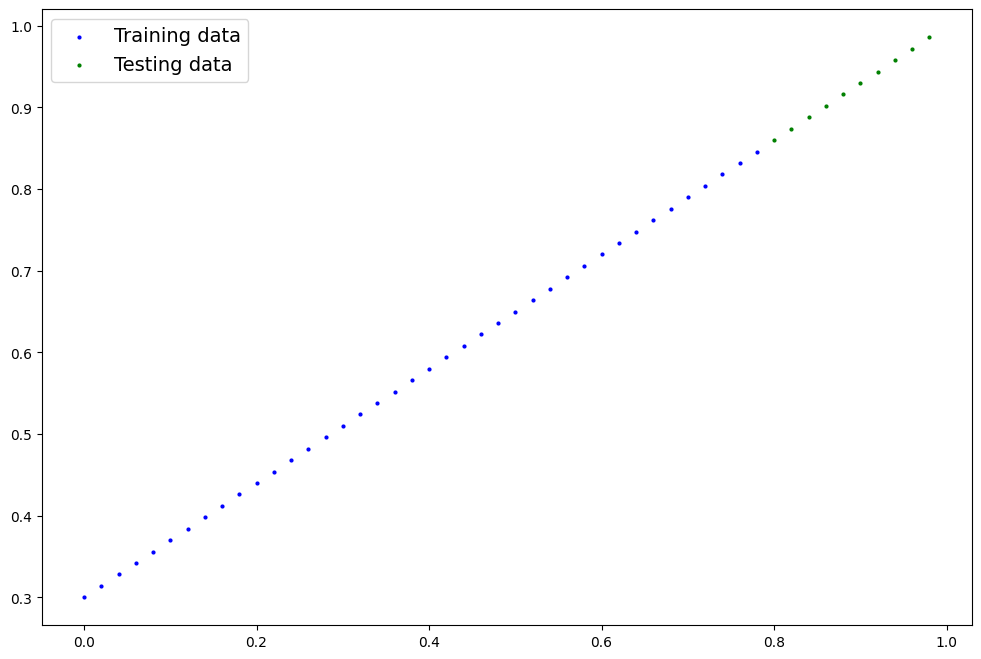

In [6]:
plot_predictions(X_train, y_train, X_test, y_test)

## 2. Build the model

In [7]:
# Create a linear regression model class
class LinearRegressionModel(nn.Module): # Inherit from nn.Module, as it is the base class for all neural network modules, like a lego block to build models
    def __init__(self):
        super().__init__()
        self.weights: nn.Parameter = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        self.bias: nn.Parameter = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
    
    def forward(self, X: torch.Tensor) -> torch.Tensor:
        return self.weights * X + self.bias

In [8]:
# Create a randmom seed
torch.manual_seed(42)

# Create an instance of the model
model_0 = LinearRegressionModel()
model_0.to(device)

list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], device='mps:0', requires_grad=True),
 Parameter containing:
 tensor([0.1288], device='mps:0', requires_grad=True)]

In [9]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367], device='mps:0')),
             ('bias', tensor([0.1288], device='mps:0'))])

### Making prediction using `torch.inference_mode()`

To check our model's predictive power, let's see how well it predicts `y_test` based on `X_test`.

In [10]:
# Making predictions using torcch.inference_mode()
with torch.inference_mode():
    y_preds = model_0(X_test.to(device))

print(f"Number of testing samples: {len(y_test)}")
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predictions: {y_preds}")

Number of testing samples: 10
Number of predictions made: 10
Predictions: tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]], device='mps:0')


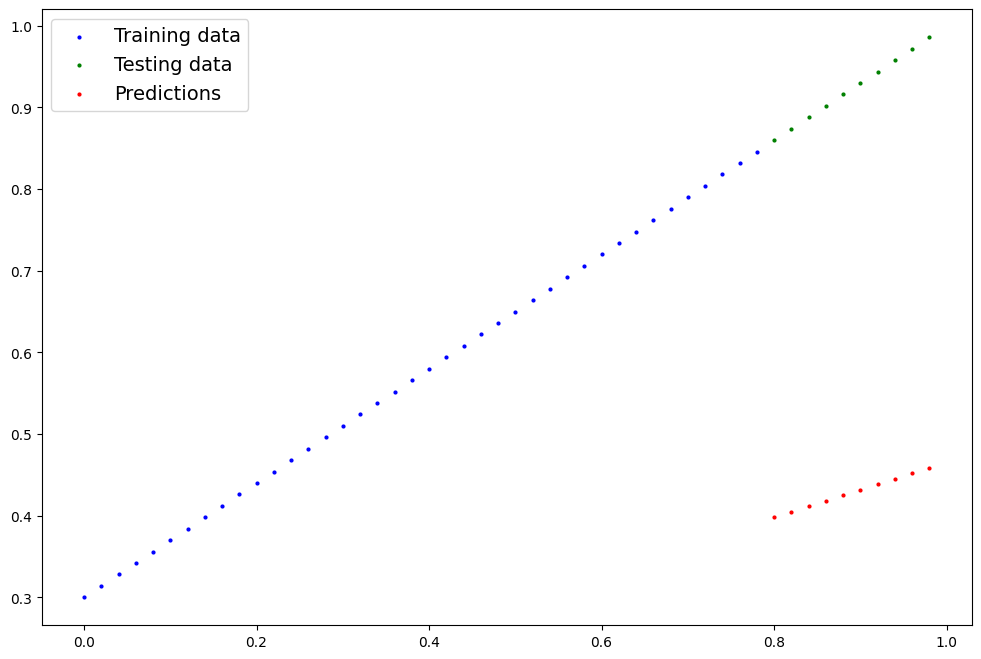

In [11]:
plot_predictions(X_train, y_train, X_test, y_test, y_preds.cpu())

In [12]:
y_test - y_preds.cpu()

tensor([[0.4618],
        [0.4691],
        [0.4764],
        [0.4836],
        [0.4909],
        [0.4982],
        [0.5054],
        [0.5127],
        [0.5200],
        [0.5272]])

## 3. Training the model

The whole idea of training is for a model to move from some *unknown* paramtetrs (maybe random) to some _known_ parameters.

In other words, moving from poor representation of our data to a better representation of our data

In [13]:
loss_fn = nn.L1Loss() # Mean Absolute Error (MAE)

# Create the optimizer
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.005)

torch.manual_seed(42)


# Set number of epochs
epochs = 200 

# Create empty lists to store training and testing loss values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    # Set the model to training mode
    model_0.train()
    
    # 1. Forward pass
    y_pred = model_0(X_train.to(device))
    
    # 2. Calculate the loss
    loss = loss_fn(y_pred, y_train.to(device))
    
    # 3. Zero gradients
    optimizer.zero_grad()
    
    # 4. Backward pass
    loss.backward()
    
    # 5. Update the weights
    optimizer.step()
    
    with torch.inference_mode():
        # Set the model to evaluation mode
        model_0.eval()
        # Make predictions on the test data
        test_pred = model_0(X_test.to(device))
        # Calculate the test loss
        test_loss = loss_fn(test_pred, y_test.to(device))
        # Print out what's happening
        if epoch % 10 == 0:
            print(f"Epoch: {epoch} | Train Loss: {loss:.4f} | Test Loss: {test_loss:.4f}")
    
        # Store the loss values for plotting later
        train_loss_values.append(loss.cpu().item())
        test_loss_values.append(test_loss.cpu().item())
        epoch_count.append(epoch)

Epoch: 0 | Train Loss: 0.3129 | Test Loss: 0.4851
Epoch: 10 | Train Loss: 0.2434 | Test Loss: 0.3906
Epoch: 20 | Train Loss: 0.1739 | Test Loss: 0.2961
Epoch: 30 | Train Loss: 0.1044 | Test Loss: 0.2016
Epoch: 40 | Train Loss: 0.0425 | Test Loss: 0.1087
Epoch: 50 | Train Loss: 0.0263 | Test Loss: 0.0387
Epoch: 60 | Train Loss: 0.0264 | Test Loss: 0.0282
Epoch: 70 | Train Loss: 0.0195 | Test Loss: 0.0456
Epoch: 80 | Train Loss: 0.0159 | Test Loss: 0.0394
Epoch: 90 | Train Loss: 0.0108 | Test Loss: 0.0191
Epoch: 100 | Train Loss: 0.0058 | Test Loss: 0.0125
Epoch: 110 | Train Loss: 0.0009 | Test Loss: 0.0004
Epoch: 120 | Train Loss: 0.0017 | Test Loss: 0.0029
Epoch: 130 | Train Loss: 0.0007 | Test Loss: 0.0023
Epoch: 140 | Train Loss: 0.0003 | Test Loss: 0.0013
Epoch: 150 | Train Loss: 0.0004 | Test Loss: 0.0002
Epoch: 160 | Train Loss: 0.0006 | Test Loss: 0.0001
Epoch: 170 | Train Loss: 0.0005 | Test Loss: 0.0010
Epoch: 180 | Train Loss: 0.0004 | Test Loss: 0.0000
Epoch: 190 | Train Loss

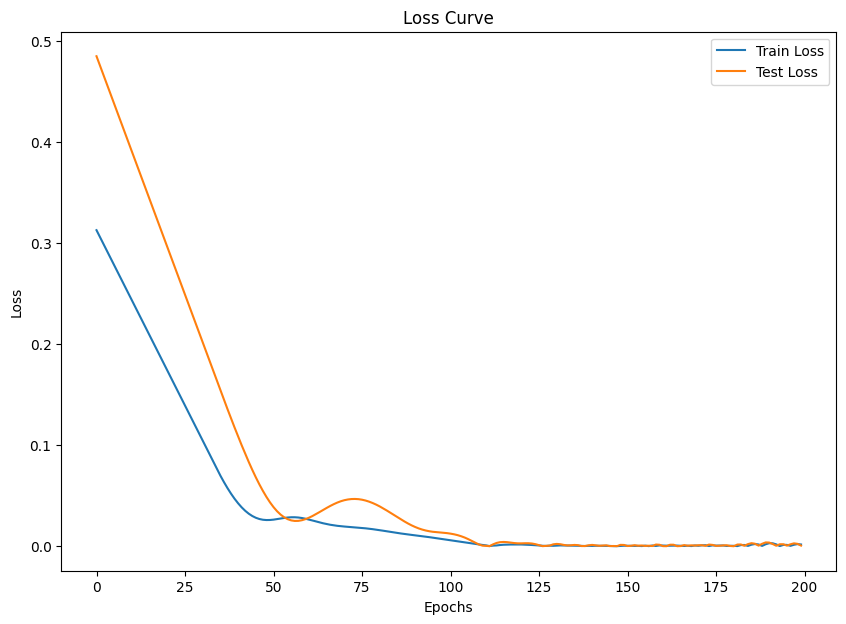

OrderedDict([('weights', tensor([0.6995], device='mps:0')),
             ('bias', tensor([0.2998], device='mps:0'))])

In [14]:
plt.figure(figsize=(10, 7))
plt.plot(epoch_count, train_loss_values, label="Train Loss")
plt.plot(epoch_count, test_loss_values, label="Test Loss")
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

model_0.state_dict()

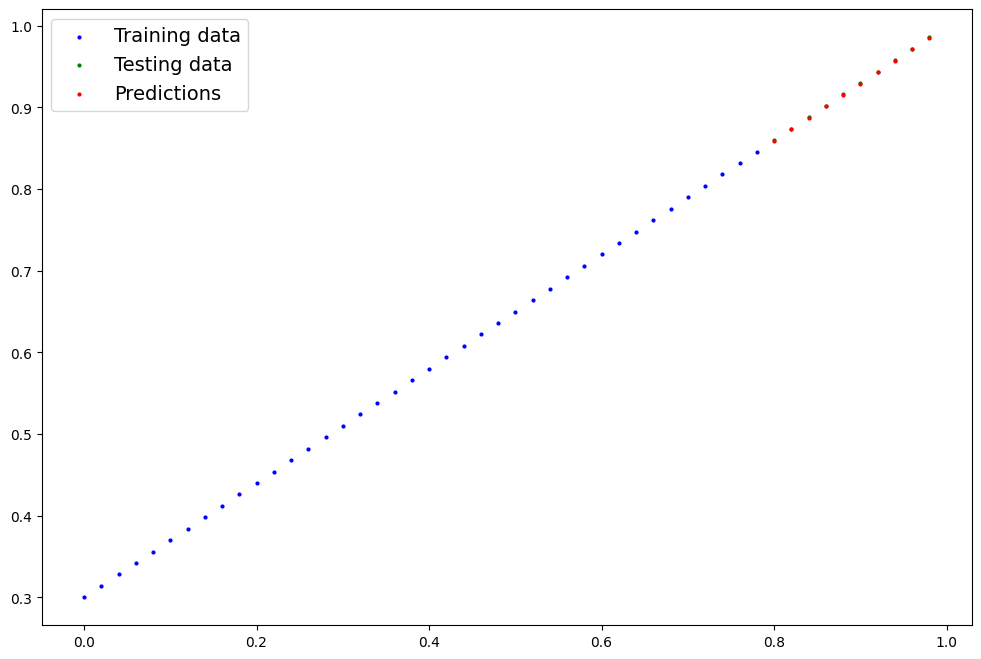

In [15]:
with torch.inference_mode():
    y_preds = model_0(X_test.to(device))
    plot_predictions(X_train, y_train, X_test, y_test, y_preds.cpu())

## Saving a PyTorch model

There are three main methods to know about for saving and loading models in pytorch
1. `torch.save()` allows us to save the model in python pickle format.
2. `torch.load()` allows us to load the saved pytorch model
3. `torch.nn.Module.load_state_dict()` allows us to load a model's saved state dictionary.

Saving model to: models/01_pytorch_workflow_model_0.pth
OrderedDict({'weights': tensor([0.6995], device='mps:0'), 'bias': tensor([0.2998], device='mps:0')})


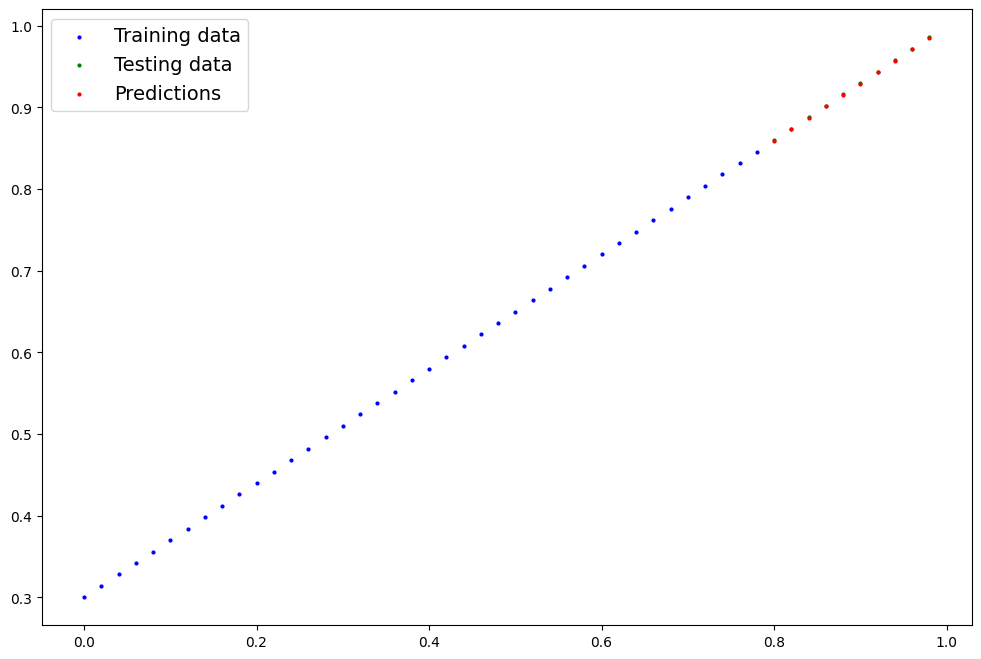

In [16]:
# Saving our PyTorch model
from pathlib import Path

# 1. Create a models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create a model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

# Loading a PyTorch model
# 1. Create a new instance of the model class
model_1 = LinearRegressionModel()

# 2. Load the state dict (parameters) into the new model instance
model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))
model_1.to(device)
print(model_1.state_dict())

# 3. Evaluate the loaded model
with torch.inference_mode():
    model_1.eval()
    y_preds_loaded = model_1(X_test.to(device))
    plot_predictions(X_train, y_train, X_test, y_test, y_preds_loaded.cpu())


## Putting it all together

In [17]:
# Imports
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np            

# If GPU device is available, use it, else fallback to CPU
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
print(f"Using device: {device} with PyTorch version: {torch.__version__}")


Using device: mps with PyTorch version: 2.8.0


In [18]:
# Creating some data using the linmear regression formula: y = weight * X + bias
weight = 0.6125
bias = 0.7777

# Create range values
start = 0
end = 1
step = 0.02

# Create X and y (features and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1) # shape (n_samples, n_features) -> (50, 1)
y = weight * X + bias # shape (n_samples, n_features) -> (50, 1)
print(f"{X.shape=}, {y.shape=}")
print(f"{len(X)=},\n{len(y)=}")

X.shape=torch.Size([50, 1]), y.shape=torch.Size([50, 1])
len(X)=50,
len(y)=50


In [19]:
# Train/test split
train_split = int(0.8 * len(X)) # 80% of data to train on, 20% to test on
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

print(f"{len(X_train)=}, {len(y_train)=}")
print(f"{len(X_test)=}, {len(y_test)=}")

len(X_train)=40, len(y_train)=40
len(X_test)=10, len(y_test)=10


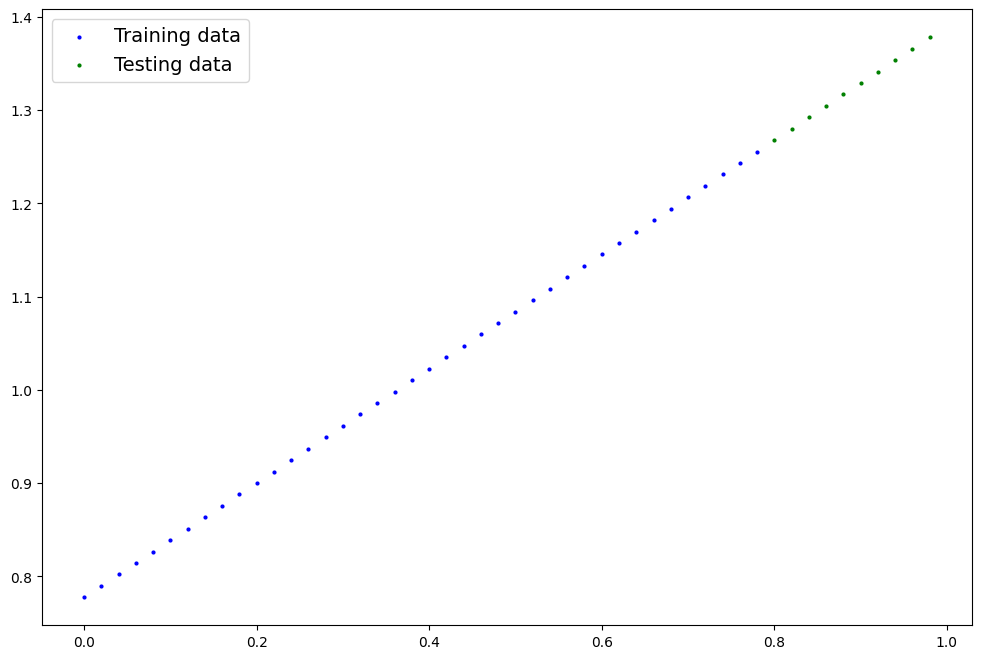

In [20]:
# Plot the data
plot_predictions(X_train.cpu(), y_train.cpu(), X_test.cpu(), y_test.cpu())

## 6.2 Building a PyTorch Linear model

In [21]:
# Creating a PyTorch Linear model by subclassing nn.Module
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        # using nn.Linear() layer (also known as fully connected layer or dense layer or linear transform)
        self.linear_layer = nn.Linear(in_features=1, out_features=1)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(X)
    
# Create a random seed
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1.to(device)
print(model_1.state_dict())

OrderedDict({'linear_layer.weight': tensor([[0.7645]], device='mps:0'), 'linear_layer.bias': tensor([0.8300], device='mps:0')})


### 6.3 Training

For training, we need:
* Loss Function
* Optimizer
* Training Loop
* Testing Loop

Epoch: 0 | Train Loss: 0.1116 | Test Loss: 0.1782
Epoch: 10 | Train Loss: 0.0421 | Test Loss: 0.0837
Epoch: 20 | Train Loss: 0.0177 | Test Loss: 0.0065
Epoch: 30 | Train Loss: 0.0118 | Test Loss: 0.0248
Epoch: 40 | Train Loss: 0.0105 | Test Loss: 0.0275
Epoch: 50 | Train Loss: 0.0057 | Test Loss: 0.0051
Epoch: 60 | Train Loss: 0.0007 | Test Loss: 0.0009
Epoch: 70 | Train Loss: 0.0010 | Test Loss: 0.0011
Epoch: 80 | Train Loss: 0.0007 | Test Loss: 0.0019
Epoch: 90 | Train Loss: 0.0005 | Test Loss: 0.0012
Epoch: 100 | Train Loss: 0.0008 | Test Loss: 0.0019
Epoch: 110 | Train Loss: 0.0004 | Test Loss: 0.0009
Epoch: 120 | Train Loss: 0.0002 | Test Loss: 0.0001
Epoch: 130 | Train Loss: 0.0003 | Test Loss: 0.0004
Epoch: 140 | Train Loss: 0.0011 | Test Loss: 0.0016
Epoch: 150 | Train Loss: 0.0019 | Test Loss: 0.0004
Epoch: 160 | Train Loss: 0.0012 | Test Loss: 0.0029
Epoch: 170 | Train Loss: 0.0014 | Test Loss: 0.0010
Epoch: 180 | Train Loss: 0.0017 | Test Loss: 0.0037
Epoch: 190 | Train Loss

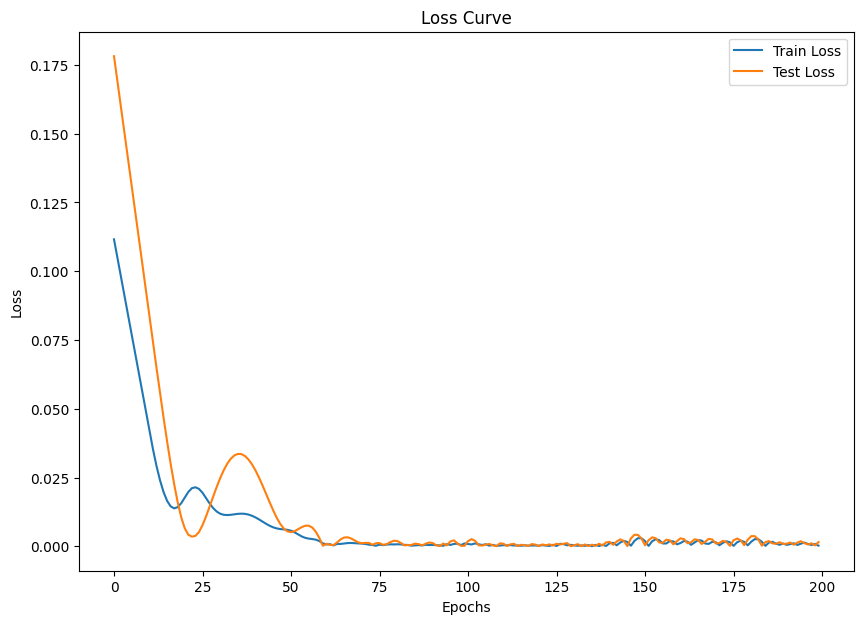

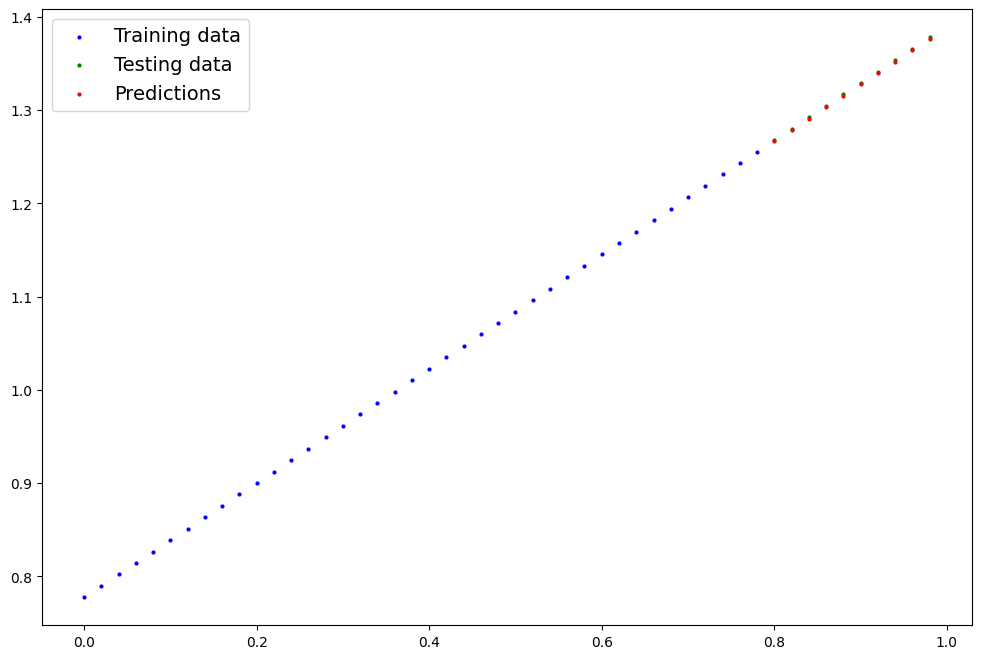

In [22]:
loss_func = nn.L1Loss() # Mean Absolute Error (MAE)
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.005)

# Train the model
torch.manual_seed(42)
epochs = 200

# Init the empty lists to store loss values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    # Set the model to training mode
    model_1.train()

    # 1. Forward pass
    y_pred = model_1(X_train)

    # 2. Calculate the loss
    loss = loss_func(y_pred, y_train)

    # 3. Zero gradients
    optimizer.zero_grad()

    # 4. Backward pass
    loss.backward()

    # 5. Update the weights
    optimizer.step()

    ## Testign the model
    model_1.eval()
    with torch.inference_mode():
        # Make predictions on the test data
        test_pred = model_1(X_test)

        test_loss = loss_func(test_pred, y_test)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Train Loss: {loss:.4f} | Test Loss: {test_loss:.4f}")
    
    # Store the loss values for plotting later
    train_loss_values.append(loss.cpu().item())
    test_loss_values.append(test_loss.cpu().item())
    epoch_count.append(epoch)

print(model_1.state_dict())

plt.figure(figsize=(10, 7))
plt.plot(epoch_count, train_loss_values, label="Train Loss")
plt.plot(epoch_count, test_loss_values, label="Test Loss")
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

with torch.inference_mode():
    y_preds = model_1(X_test.to(device))
    plot_predictions(X_train.cpu(), y_train.cpu(), X_test.cpu(), y_test.cpu(), y_preds.cpu())

In [24]:
# Saving and loading the model
from pathlib import Path

# 1. Create a models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create a model save path
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), f=MODEL_SAVE_PATH)

# Loading a PyTorch model
# 1. Create a new instance of the model class
model_1_loaded = LinearRegressionModelV2()
print(model_1_loaded.state_dict())

# 2. Load thge state dict from the saved model file
model_1_loaded.load_state_dict(torch.load(MODEL_SAVE_PATH))
model_1_loaded.to(device)
print(model_1_loaded.state_dict())

# 3. Evaluate the loaded model
with torch.inference_mode():
    model_1_loaded.eval()
    y_preds = model_1(X_test)
    y_preds_loaded = model_1_loaded(X_test)
    print(torch.eq(y_preds, y_preds_loaded))


Saving model to: models/01_pytorch_workflow_model_1.pth
OrderedDict({'linear_layer.weight': tensor([[-0.2343]]), 'linear_layer.bias': tensor([0.9186])})
OrderedDict({'linear_layer.weight': tensor([[0.6118]], device='mps:0'), 'linear_layer.bias': tensor([0.7768], device='mps:0')})
tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='mps:0')
